In [1]:
import os
import random
import torch
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import dill
import matplotlib.pyplot as plt
from datetime import datetime
from copy import deepcopy
import torch
from torch import nn
import torch.nn.functional as F
from functools import partial
import lovely_tensors as lt
lt.monkey_patch()

import csng
from csng.models.inverted_encoder import InvertedEncoder, InvertedEncoderBrainreader
from csng.models.ensemble import EnsembleInvEnc
from csng.models.utils.gan import init_decoder as init_gan_decoder
from csng.models.utils.cnn import init_decoder as init_cnn_decoder
from csng.models.inverted_encoder_decoder import InvertedEncoderDecoder
from csng.utils.mix import plot_comparison, seed_all, check_if_data_zscored, update_config_paths, update_config
from csng.utils.data import standardize, normalize, crop
from csng.utils.comparison import find_best_ckpt, load_decoder_from_ckpt, plot_reconstructions, plot_metrics, eval_decoder, SavedReconstructionsDecoder, collect_all_preds_and_targets
from csng.losses import get_metrics
from csng.data import get_dataloaders, get_sample_data
from csng.brainreader_mouse.encoder import get_encoder as get_encoder_brainreader
from csng.mouse_v1.encoder import get_encoder as get_encoder_sensorium_mouse_v1
from csng.cat_v1.encoder import get_encoder as get_encoder_cat_v1

# from monkeysee.SpatialBased.decoding_wrapper import MonkeySeeDecoder


### set paths
DATA_PATH = os.environ["DATA_PATH"]
DATA_PATH_CAT_V1 = os.path.join(DATA_PATH, "cat_V1_spiking_model", "50K_single_trial_dataset")
DATA_PATH_MOUSE_V1 = os.path.join(DATA_PATH, "mouse_v1_sensorium22")
DATA_PATH_BRAINREADER = os.path.join(DATA_PATH, "brainreader")

print(f"{DATA_PATH=}")
print(f"{DATA_PATH_CAT_V1=}")
print(f"{DATA_PATH_MOUSE_V1=}")
print(f"{DATA_PATH_BRAINREADER=}")

DATA_PATH='/media/jan/ext_ssd/csng_data'
DATA_PATH_CAT_V1='/media/jan/ext_ssd/csng_data/cat_V1_spiking_model/50K_single_trial_dataset'
DATA_PATH_MOUSE_V1='/media/jan/ext_ssd/csng_data/mouse_v1_sensorium22'
DATA_PATH_BRAINREADER='/media/jan/ext_ssd/csng_data/brainreader'


In [2]:
!export CUDA_LAUNCH_BLOCKING="1"

In [3]:
### setup config
config = {
    "device": os.environ["DEVICE"],
    "seed": 0,
    "data": {
        "mixing_strategy": "parallel_min", # needed only with multiple base dataloaders
        "max_training_batches": None,
    },
    "crop_wins": {
        "cat_v1": (20, 20),
        "6": (36, 64),
        "21067-10-18": (22, 36),
    },
}

print(f"... Running on {config['device']} ...")
seed_all(config["seed"])

... Running on cuda:0 ...


---
# Models

## MindEye2

In [ ]:
decoder = SavedReconstructionsDecoder(
    reconstructions=torch.load(os.path.join(
        DATA_PATH,
        "mindeye",
        "evals",
        # "csng_mouse_v1__24-03-25_22-50",
        # "subj21067-10-18_reconstructions.pt"
        # "csng_cat_v1__08-03-25_11-24",
        # "subjcat_v1_reconstructions_zscored.pt"
        "csng_18-02-25_19-45",
        "subj06_reconstructions_zscored.pt",
    ), pickle_module=dill),
    # data_key="21067-10-18",
    # data_key="cat_v1",
    data_key="6",
    # zscore_reconstructions=True,
    zscore_reconstructions=False,
    device=config["device"],
)

## GAN

In [4]:
### load ckpt and init
decoder_name = "2025-04-03_02-35-59__decoder" # B-6
# decoder_name = "2025-03-24_10-06-33__decoder" # M-1
decoder, ckpt = load_decoder_from_ckpt(
    ckpt_path=os.path.join(
        DATA_PATH,
        "models",
        "gan",
        decoder_name.split("__")[0],
        f"{decoder_name.split('__')[1]}.pt",
    ),
    device=config["device"],
    load_best=True,
    load_only_core=False,
    strict=True,
)
decoder.eval()

[WARNING] Loading GAN state_dict without the optimizer states.


MultiReadIn(
  (readins): ModuleDict(
    (6): ModuleList(
      (0): MEIReadIn(
        (pointwise_conv): Sequential(
          (0): Dropout2d(p=0.2, inplace=False)
          (1): Conv2d(8587, 480, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(480, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (3): LeakyReLU(negative_slope=0.01)
        )
        (resp_transform): Identity()
        (ctx_net): Sequential(
          (0): Linear(in_features=33, out_features=128, bias=True)
          (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): LeakyReLU(negative_slope=0.01)
          (3): Dropout(p=0.15, inplace=False)
          (4): Linear(in_features=128, out_features=2304, bias=True)
          (5): Identity()
        )
        (neuron_embed): Embedding(8587, 32)
      )
    )
  )
  (core): GAN(
    (G): Generator(
      (layers): Sequential(
        (0): Conv2d(480, 480, kernel_size=(7, 7),

## Patterns

### Simple shapes

In [5]:
from PIL import Image, ImageDraw
import math

In [6]:
def rotate_point(x, y, cx, cy, angle_deg):
    """Rotate point (x, y) around center (cx, cy) by angle_deg (degrees)."""
    angle_rad = math.radians(angle_deg)
    cos_a = math.cos(angle_rad)
    sin_a = math.sin(angle_rad)
    # Translate to origin, rotate, translate back
    x_new = cx + (x - cx) * cos_a - (y - cy) * sin_a
    y_new = cy + (x - cx) * sin_a + (y - cy) * cos_a
    return x_new, y_new

def generate_pattern(width, height, objects):
    # Create a new black grayscale image
    image = Image.new('L', (width, height), 0)  # 'L' mode for grayscale, 0 for black
    draw = ImageDraw.Draw(image)

    for obj in objects:
        shape = obj.get("shape")
        grayscale = obj.get("grayscale", 255)  # Default to white
        rotation = obj.get("rotation", 0)  # Rotation angle in degrees, default 0

        if shape == "circle":
            center = obj.get("center", (width // 2, height // 2))  # (x, y)
            radius = obj.get("radius", min(width, height) // 10)
            bbox = (center[0] - radius, center[1] - radius, center[0] + radius, center[1] + radius)
            draw.ellipse(bbox, fill=grayscale)

        elif shape == "rectangle":
            top_left = obj.get("top_left", (width // 4, height // 4))  # (x, y)
            width_rect = obj.get("width", width // 5)
            height_rect = obj.get("height", height // 5)
            # Compute the four corners
            corners = [
                top_left,  # Top-left
                (top_left[0] + width_rect, top_left[1]),  # Top-right
                (top_left[0] + width_rect, top_left[1] + height_rect),  # Bottom-right
                (top_left[0], top_left[1] + height_rect)  # Bottom-left
            ]
            # Compute rectangle center for rotation
            center_x = top_left[0] + width_rect / 2
            center_y = top_left[1] + height_rect / 2
            # Rotate each corner if rotation is specified
            if rotation != 0:
                corners = [rotate_point(x, y, center_x, center_y, rotation) for x, y in corners]
            # Draw as a polygon
            draw.polygon(corners, fill=grayscale)

        elif shape == "triangle":
            vertices = obj.get("vertices", [
                (width // 2, height // 4),  # Top
                (width // 4, 3 * height // 4),  # Bottom-left
                (3 * width // 4, 3 * height // 4)  # Bottom-right
            ])
            # Compute centroid for rotation
            center_x = sum(x for x, y in vertices) / 3
            center_y = sum(y for x, y in vertices) / 3
            # Rotate vertices if rotation is specified
            if rotation != 0:
                vertices = [rotate_point(x, y, center_x, center_y, rotation) for x, y in vertices]
            draw.polygon(vertices, fill=grayscale)

    image = np.array(image).astype(np.float32)
    image = image / 255.0

    return image

In [7]:
def generate_sinusoidal_grating(
    width,
    height,
    orientation=0,
    spatial_frequency=0.05,
    phase=0,
    contrast=1.0,
    background=128,
):
    """
    Generate a grayscale sinusoidal grating image.
    
    Parameters:
    - width, height: Image dimensions in pixels.
    - orientation: Grating angle in degrees (0=horizontal, 90=vertical).
    - spatial_frequency: Cycles per pixel.
    - phase: Phase shift in radians.
    - contrast: Contrast level (0 to 1).
    - background: Background intensity (0 to 255, default 128 for mid-gray).
    
    Returns:
    - PIL Image object (grayscale).
    """
    # Convert orientation to radians
    theta = np.radians(orientation)
    cos_theta = np.cos(theta)
    sin_theta = np.sin(theta)
    
    # Create coordinate grid
    x = np.arange(width)
    y = np.arange(height)
    x, y = np.meshgrid(x, y)
    
    # Compute the grating phase for each pixel
    # Linear combination: x*cos(theta) + y*sin(theta)
    grating = 2 * np.pi * spatial_frequency * (x * cos_theta + y * sin_theta) + phase
    
    # Compute intensity: background + contrast * 127 * sin(grating)
    intensity = background + contrast * 127 * np.sin(grating)
    
    # Clip to valid grayscale range and convert to uint8
    intensity = np.clip(intensity, 0, 255).astype(np.uint8)
    
    # Create PIL image from array
    image = Image.fromarray(intensity, mode='L')
    
    return image

In [8]:
def generate_stim_resp_pairs(stim_objs, width, height, encoder_pred_fn, z_score=True, device="cuda", show_stims=False):
    stims = []
    for single_stim_objs in stim_objs:
        if len(single_stim_objs) == 1 and single_stim_objs[0].get("shape") == "grating":
            # Generate sinusoidal grating
            stim = generate_sinusoidal_grating(
                width=width,
                height=height,
                orientation=single_stim_objs[0].get("orientation", 0),
                spatial_frequency=single_stim_objs[0].get("spatial_frequency", 0.05),
                phase=single_stim_objs[0].get("phase", 0),
                contrast=single_stim_objs[0].get("contrast", 1.0),
                background=single_stim_objs[0].get("background", 128),
            )
        else:
            stim = generate_pattern(width=width, height=height, objects=single_stim_objs)
        stims.append(stim)
        if show_stims:
            plt.figure(figsize=(2, 2))
            plt.axis("off")
            plt.imshow(stim, cmap='gray')
            plt.show()
    stims = np.stack(stims, axis=0)
    stims = torch.from_numpy(stims).to(device)
    stims = stims.unsqueeze(1)  # add channel dim
    stims = stims / 255.0  # normalize to [0, 1]

    if z_score:
        stims = normalize(stims, dim=(2, 3))

    resp = encoder_pred_fn(stims).detach().cpu()

    return stims, resp

[INFO] Loading encoder checkpoint from /media/jan/ext_ssd/csng_data/models/encoders/encoder_b6.pt


/home/jan/Desktop/Dev/csng/decoding-brain-activity/pkgs/neuralpredictors/neuralpredictors/layers/readouts/base.py:72: UserWarning: Use of 'gamma_readout' is deprecated. Please consider using the readout's feature-regularization parameter instead
  warnings.warn(
/home/jan/Desktop/Dev/csng/decoding-brain-activity/pkgs/neuralpredictors/neuralpredictors/layers/readouts/base.py:88: UserWarning: Readout is NOT initialized with mean activity but with 0!
  warnings.warn("Readout is NOT initialized with mean activity but with 0!")


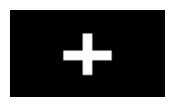

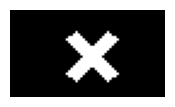

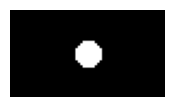

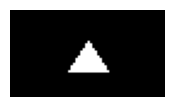

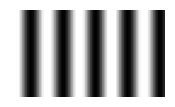

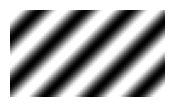

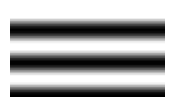

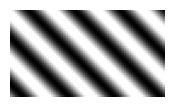

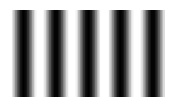

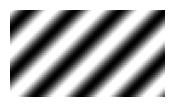

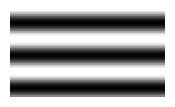

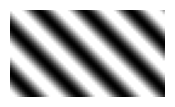

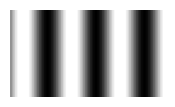

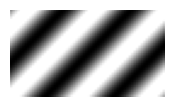

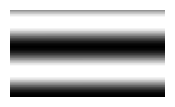

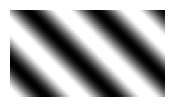

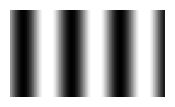

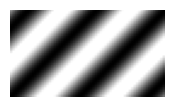

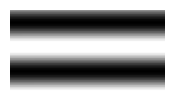

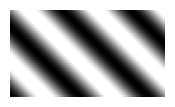

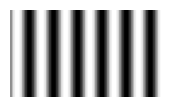

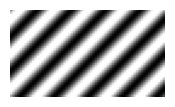

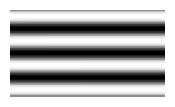

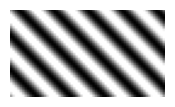

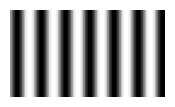

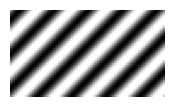

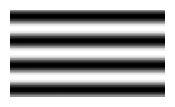

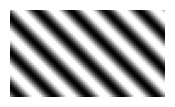

In [9]:
### brainreader encoder
data_key = "6"
encoder = get_encoder_brainreader(
    os.path.join(DATA_PATH, "models", "encoders", "encoder_b6.pt"),
    device=config["device"],
)

### mouse v1 encoder
# data_key = "21067-10-18"
# encoder = get_encoder_sensorium_mouse_v1(
#     os.path.join(DATA_PATH, "models", "encoders", "encoder_m1.pt"),
#     device=config["device"],
# )

encoder_pred_fn = partial(encoder, data_key=data_key, neuron_coords=None)

objs = [
    # [
    #     {"shape": "rectangle", "top_left": (22, 17), "width": 20, "height": 3, "grayscale": 255},
    #     {"shape": "rectangle", "top_left": (22, 17), "width": 20, "height": 3, "grayscale": 255, "rotation": 90},
    # ],
    # [
    #     {"shape": "rectangle", "top_left": (22, 17), "width": 24, "height": 4.5, "grayscale": 255, "rotation": 45},
    #     {"shape": "rectangle", "top_left": (22, 17), "width": 24, "height": 4.5, "grayscale": 255, "rotation": 135},
    # ],
    # [
    #     {"shape": "circle", "center": (32, 18), "radius": 6, "grayscale": 255},
    # ],
    # [
    #     {"shape": "triangle", "vertices": [(32, 10), (22, 25), (42, 25)], "grayscale": 255},
    # ],

    [
        {"shape": "rectangle", "top_left": (22, 17), "width": 19, "height": 3, "grayscale": 255},
        # {"shape": "rectangle", "top_left": (12, 16), "width": 38, "height": 3, "grayscale": 255},
        {"shape": "rectangle", "top_left": (24, 17), "width": 16, "height": 3, "grayscale": 255, "rotation": 90},
        # {"shape": "rectangle", "top_left": (18, 17), "width": 28, "height": 3, "grayscale": 255, "rotation": 90},
    ],
    [
        {"shape": "rectangle", "top_left": (22, 17), "width": 24, "height": 4.5, "grayscale": 255, "rotation": 45},
        {"shape": "rectangle", "top_left": (22, 17), "width": 24, "height": 4.5, "grayscale": 255, "rotation": 135},
    ],
    [
        {"shape": "circle", "center": (32, 18), "radius": 5, "grayscale": 255},
    ],
    [
        {"shape": "triangle", "vertices": [(32, 13), (24, 25), (40, 25)], "grayscale": 255},
    ],
    
    # [
    #     {"shape": "rectangle", "top_left": (42, 17), "width": 15, "height": 2.5, "grayscale": 255},
    #     {"shape": "rectangle", "top_left": (42, 17), "width": 15, "height": 2.5, "grayscale": 255, "rotation": 90},
    #     {"shape": "circle", "center": (14, 18), "radius": 5, "grayscale": 255},
    #     # {"shape": "triangle", "vertices": [(32, 10), (22, 25), (42, 25)], "grayscale": 255},
    #     # need smaller triangle
    #     {"shape": "triangle", "vertices": [(32, 12), (25, 22), (38, 22)], "grayscale": 255},
    # ],
    *[[
        {"shape": "grating", "orientation": ori, "spatial_frequency": 0.075, "phase": 26, "contrast": 1, "background": 160},
    ] for ori in range(0, 360, 45)],
    *[[
        {"shape": "grating", "orientation": ori, "spatial_frequency": 0.05, "phase": 0, "contrast": 1, "background": 160},
    ] for ori in range(0, 360, 45)],
    *[[
        {"shape": "grating", "orientation": ori, "spatial_frequency": 0.1, "phase": 0, "contrast": 1, "background": 160},
    ] for ori in range(0, 360, 45)],
]

stim, resp = generate_stim_resp_pairs(
    stim_objs=objs,
    width=64,
    height=36,
    encoder_pred_fn=encoder_pred_fn,
    device=config["device"],
    show_stims=True,
)

In [10]:
config["crop_wins"][data_key]=(22,36)

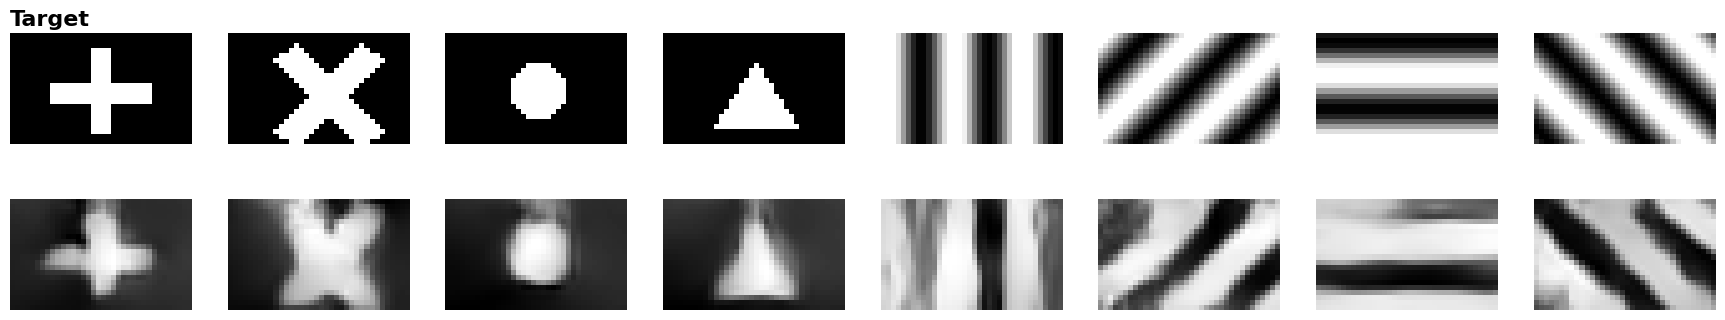

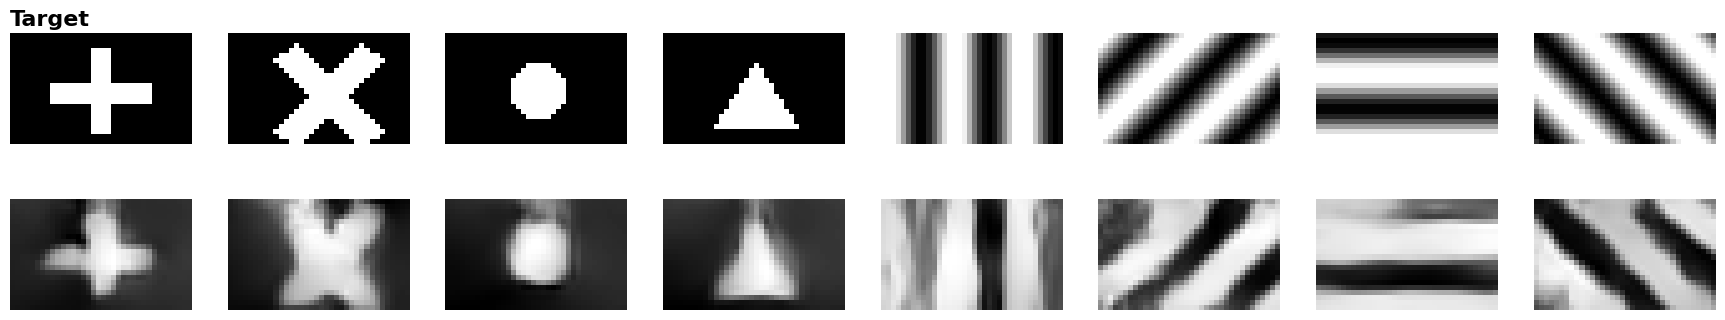

In [11]:
### predict
with torch.no_grad():
    stim_pred = decoder(
        resp.to(config["device"]),
        data_key=data_key,
        neuron_coords=None,
    ).detach().cpu()

plot_comparison(
    target=crop(stim[:8], config["crop_wins"][data_key]).cpu(),
    # target=crop(stim, (22, 36)).cpu(),
    pred=crop(stim_pred[:8], config["crop_wins"][data_key]).cpu(),
    # pred=crop(stim_pred[:8], (22, 36)).cpu(),
    pred_title=None,
)

In [12]:
neuron_maps = torch.load("stim_resp_neuron_maps_6.pt", pickle_module=dill).detach().cpu()
neuron_maps_com = torch.load("stim_resp_neuron_maps_compressed_6.pt", pickle_module=dill).detach().cpu()
meis = decoder.readins["6"][0].meis # (1, n_neurons, H, W)

In [13]:
sorted_neuron_idxs = resp.argsort(dim=1, descending=True) # (n_stims, n_neurons)

In [14]:
mei_recons = (meis.expand(stim_pred.shape[0], -1, -1, -1).cuda() * resp.unsqueeze(-1).unsqueeze(-1).cuda()).sum(1, keepdim=True) # (n_stims, n_neurons, H, W)

In [22]:
k = 1
# mei_recons_top_k = (
#     meis.expand(stim_pred.shape[0], -1, -1, -1).cuda().gather(index=sorted_neuron_idxs.cuda().unsqueeze(-1).unsqueeze(-1), dim=1)
#     * resp.unsqueeze(-1).unsqueeze(-1).cuda().gather(index=sorted_neuron_idxs.cuda().unsqueeze(-1).unsqueeze(-1), dim=1).unsqueeze(-1)
# )[:,:k]
_mei_recons_top_k = (meis.expand(stim_pred.shape[0], -1, -1, -1).cuda() * resp.unsqueeze(-1).unsqueeze(-1).cuda()) # (n_stims, n_neurons, H, W)
mei_recons_top_k = []
for b in range(resp.size(0)):
    mei_recons_top_k.append(_mei_recons_top_k[b][sorted_neuron_idxs[b][:k]].sum(0, keepdim=True)) # (n_neurons, H, W)
mei_recons_top_k = torch.stack(mei_recons_top_k, dim=0) # (n_stims, n_neurons, H, W)
# mei_recons_top_k = mei_recons_top_k / mei_recons_top_k.max() # normalize to [0, 1]

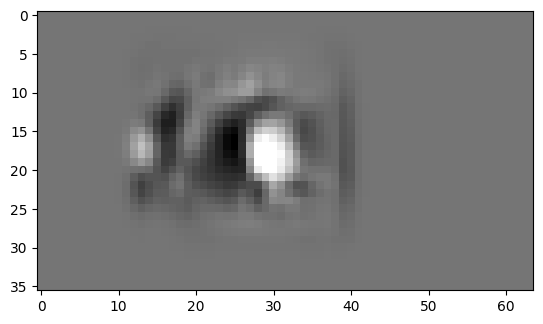

In [23]:
plt.imshow(mei_recons_top_k[2, 0].cpu(), cmap="gray")

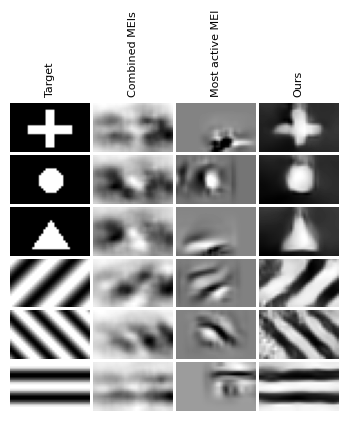

In [30]:
ch = 2
max_n = None
crop_win = (22, 36)
# crop_win = None
indices = np.array([0, 2, 3, 5, 23, 26])
plot_reconstructions(
    runs={
        "Combined MEIs": {"stim_pred_best": [crop(mei_recons, crop_win)[:max_n][indices]]},
        "Most active MEI": {"stim_pred_best": [crop(mei_recons_top_k, crop_win)[:max_n][indices]]},
        "Ours": {"stim_pred_best": [crop(stim_pred, crop_win)[:max_n][indices]]},
        # "MEIs": {"stim_pred_best": [crop(meis[:,[ch]].expand(stim_pred.shape[0], -1, -1, -1), crop_win)[:max_n]]},
        # "MEI recons": {"stim_pred_best": [mei_recons[:max_n]]},
        # "Neuron maps": {"stim_pred_best": [neuron_maps[:,[ch]][:max_n]]},
        # "Neuron maps compressed": {"stim_pred_best": [neuron_maps_com[:,[ch]][:max_n]]},
        # "Neuron maps": {"stim_pred_best": [crop(neuron_maps[:,[ch]], crop_win)[:max_n]]},
        # "Neuron maps compressed": {"stim_pred_best": [crop(neuron_maps_com[:,[ch]], crop_win)[:max_n]]},
    },
    stim=crop(stim, crop_win)[:max_n][indices].cpu(),
    stim_label="Target",
    save_to=f"mei_recons_with_top_{data_key}.pdf",
    # save_to=os.path.join(
    #     cfg["comparison"]["save_dir"],
    #     f"reconstructions_{data_key}.{f_type}"
    # ) if cfg["comparison"]["save_dir"] else None,
)

In [ ]:
ch = 0

plot_comparison(
    target=crop(stim[:8], config["crop_wins"][data_key]).cpu(),
    # target=crop(stim, (22, 36)).cpu(),
    pred=crop(neuron_maps[:8, ch], config["crop_wins"][data_key]).cpu(),
    # pred=crop(stim_pred[:8], (22, 36)).cpu(),
    pred_title=None,
)

In [ ]:
### save
torch.save({
    "stim": stim,
    "resp": resp,
}, os.path.join(f"stim_resp_pairs_{data_key}.pt"))

torch.save({
    "stim": stim,
    "resp": resp,
    "stim_pred": stim_pred,
}, os.path.join(f"stim_resp_pairs_{data_key}_{decoder_name}.pt"))

In [ ]:
### MEIs
# meis = 

### Plot

In [ ]:
### load 
runs = dict()

### Ours
recons = torch.load("stim_resp_pairs_6_2025-04-03_02-35-59__decoder.pt", pickle_module=dill)
stim_gt = recons["stim"]
runs["Ours"] = {"stim_pred_best": [recons["stim_pred"]]}

### MindEye2
runs["MindEye2"] = {"stim_pred_best": [
    torch.load(os.path.join(DATA_PATH, "mindeye", "evals",
        "csng_18-02-25_19-45", "patterns_subj06", "subj06_test_reconstructions_zscored.pt"), pickle_module=dill)
]}

In [20]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import torch

ticks_fontsize = 17  # Font size for ticks
label_fontsize = 17  # Font size for labels

# Set publication plot style
plt.style.use('seaborn-v0_8-whitegrid')  # Clean and professional style
plt.rcParams.update({
    'font.family': 'DejaVu Sans',  # Use a clean sans-serif font
    'font.size': ticks_fontsize,
    'axes.linewidth': 1.2,
    'xtick.major.width': 1.2,
    'ytick.major.width': 1.2,
    'xtick.direction': 'out',
    'ytick.direction': 'out',
    'figure.dpi': 300,  # High resolution for publication
    'savefig.dpi': 300,
    'axes.titlesize': label_fontsize,
    'axes.labelsize': label_fontsize,
    'xtick.labelsize': ticks_fontsize,
    'ytick.labelsize': ticks_fontsize,
    'legend.fontsize': ticks_fontsize,
    'figure.autolayout': True,
})

def plot_reconstructions_horizontal(runs, stim, stim_label="Target", data_key=None, indices=None, manually_standardize=False, crop_win=None, save_to=None):
    """
    Plot reconstructions of different methods in separate rows, with target stimulus in the first row.
    Each row contains selected images displayed horizontally, with method names as y-labels on the left.
    
    Parameters:
    - runs: Dictionary of run names to their data, containing 'stim_pred_best' with predicted stimuli.
    - stim: Tensor of target stimuli (shape: [n_stim, channels, height, width]).
    - stim_label: Label for the target stimulus row (default: "Target").
    - data_key: Optional key to access specific data in 'stim_pred_best' (default: None).
    - indices: Optional list of indices to select specific images (e.g., [2, 7, 11]; default: None, uses all).
    - manually_standardize: If True, standardize images across channels and spatial dimensions (default: False).
    - crop_win: Optional window to crop images (default: None).
    - save_to: Optional file path to save the figure (default: None).
    """
    n_stim = len(indices) if indices is not None else stim.shape[0]
    fig = plt.figure(figsize=(int(n_stim * 1.3), 1.5 + int(len(runs) * 1.3)))
    grid = ImageGrid(fig, 111, nrows_ncols=(1 + len(runs), n_stim), direction="row", axes_pad=0.03, share_all=True)
    for ax in grid:
        ax.get_yaxis().set_ticks([])
        ax.get_xaxis().set_ticks([])

    def plot_imgs(imgs, curr_ax_idx):
        imgs_to_show = imgs if not manually_standardize else standardize(imgs, dim=(1,2,3))
        for img_to_show in imgs_to_show:
            grid[curr_ax_idx].imshow(img_to_show.permute(1,2,0), "gray")
            for d in ("top", "right", "left", "bottom"):
                grid[curr_ax_idx].spines[d].set_visible(False)
            curr_ax_idx += 1  # Move to next column, same row
        return curr_ax_idx

    def set_ylabel(ax, label):
        ax.set_ylabel(label, fontsize=12, ha="right", va="center", rotation=0)

    ### plot stim
    ax_idx = 0
    set_ylabel(ax=grid[ax_idx], label=stim_label)
    imgs = stim.cpu()
    if indices is not None:
        imgs = imgs[indices]  # Select specified indices
    if crop_win is not None:
        imgs = crop(imgs, crop_win)
    ax_idx = plot_imgs(imgs, curr_ax_idx=ax_idx)

    ### plot other
    for run_name in runs:
        set_ylabel(ax=grid[ax_idx], label=run_name)
        imgs = runs[run_name]["stim_pred_best"][0].cpu() if data_key is None else runs[run_name]["stim_pred_best"][0][data_key].cpu()
        if indices is not None:
            imgs = imgs[indices]  # Select specified indices
        if crop_win is not None:
            imgs = crop(imgs, crop_win)
        ax_idx = plot_imgs(imgs, curr_ax_idx=ax_idx)

    plt.show()

    if save_to is not None:
        fig.savefig(save_to, bbox_inches="tight")

    plt.close(fig)

In [ ]:
plot_reconstructions_horizontal(
    runs=runs,
    stim=stim_gt,
    stim_label="Target",
    indices=[0, 1, 2, 3, 7, 9, 14, 27],
    # data_key=data_key,
    # crop_win=cfg["crop_wins"][data_key],
    save_to="patterns.pdf",
)

## Sensitivity analysis

In [ ]:
### plot results of manual changes to responses (sensitivity)
from csng.utils.mix import plot_comparison

idx = 0
resp_vals_to_try = [1, 20, 100]

resp_std = resp.std(0)
sorted_idx = resp_std.argsort(descending=True)
with torch.no_grad():
    for resp_val in resp_vals_to_try:
        resp_mod = resp.clone()
        resp_mod[:, sorted_idx[idx]] = resp_val
        stim_pred = gan(resp_mod.to(config["device"]), data_key=sample_data_key, neuron_coords=neuron_coords[sample_dataset][sample_data_key])

        print(f"resp_val={resp_val:.3f}")
        fig = plot_comparison(target=crop(stim[:8], config["crop_wins"][sample_data_key]).cpu(), pred=crop(stim_pred[:8], config["crop_wins"][sample_data_key]).cpu(), show=True)